<a href="https://colab.research.google.com/github/LimaCondas/eco-driving-speed-rl/blob/main/My_Gym_airdrag_not_good.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**0.Install Dependencies**

---



In [2]:
!pip install gym
!pip install numpy==1.20
!pip install tensorflow==2.5.0
!pip install keras
!pip install keras-rl2
!pip install torch

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.4/15.4 MB 62.0 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.22.4
    Uninstalling numpy-1.22.4:
      Successfully uninstalled numpy-1.22.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.12.0 requires numpy<1.24,>=1.22, but you have numpy 1.20.0 which is incompatible.
pandas 1.5.3 requires numpy>=1.20.3; python_version < "3.10", but you have numpy 1.20.0 which is incompatible.
ml-dtypes 0.0.4 requires numpy>1.20, but you have numpy 1.20.0 which is incompatible.
librosa 0.10.0.post2 requires numpy!=1.22.0,!=1.22.1,!=1.22.2,>=1.20.3, but you have numpy 1.20.0 which


# **1. Test a Simple Eco-Driving Scenario**


---




> **import packages**

In [3]:
from gym import Env
from gym.spaces import Discrete, Box
import numpy as np
import random

> **This block is EcoDrivingEnv**

In [14]:
import gym
from gym import spaces
import numpy as np
import random
import math

class EcoDrivingEnv(gym.Env):
    def __init__(self):
        self.safe_speed_limit = 20 # m/s, equal 72kph
        self.time_step = 0.1 # seconds
        self.mass = 1000 # kg
        self.gravity = 9.81 # m/s^2
        self.MAX_SPEED = 40 # m/s, equal 144kph
        self.traction_coefficient = 0.8
        self.air_density = 1.02 # kg/m^3
        self.air_drag_coeficient = 0.3
        self.frontal_area = 2.35 # m^2

        self.position = 0
        self.speed = 20
        self.work = 0
        self.steps = 0
        self.total_reward = 0
        self.distance = 1000 # m
        self.max_steps = 5000 # 5000 steps, 500s
        self.max_acceleration = 1 # m/s^2

        # Action Space deaccelerate, no action, accelerate
        self.action_space = spaces.Discrete(3) 

        # Observation space [position, speed]
        self.observation_space = spaces.Box(low=np.array([0, 0]), high=np.array([np.inf, np.inf]), dtype=np.float32)

        print("Successfully Initialize EcoDrivingEnv.......")

    def reset(self):
        self.position = 0
        self.speed = 0
        self.work = 0
        self.steps = 0
        self.total_reward = 0
        return np.array([self.position, self.speed], dtype=np.float32)

    def step(self, action):
        # Apply action
        if action == 0:
            acceleration = -self.max_acceleration # -1
        elif action == 1:
            acceleration = 0
        elif action == 2:
            acceleration = self.max_acceleration # +1
        else:
            acceleration = 0

        # Calculate new speed and position
        new_speed = self.speed + acceleration * self.time_step # vt = v0 + a * dt
        new_speed = np.max(new_speed, 0,) # speed limitation

        # xt = x0 + vt + 0.5 * a * t^2
        new_position = self.position + self.speed * self.time_step + 0.5 * acceleration * (self.time_step ** 2)

        #   1. Calculate air drag force F_drag = 0.5 * rho * A * C_d * v^2
        air_drag = 0.5 * self.air_density * self.air_drag_coeficient * self.frontal_area * (new_speed ** 2)

        #   2. Calculate traction force in different scenario
        if acceleration > 0:
            traction_force = air_drag + self.traction_coefficient * self.mass * acceleration
        elif acceleration == 0:
            traction_force = air_drag # acc = 0, traction force equals air drag
        else:
            traction_force = 0 # deacceleration caused by brake, no traction force

        #   3. Calculate distance difference in time_step
        distance_diff = new_position - self.position
        # print('New Position:{}\t\t self position:{}'.format(new_position, self.position))

        #   4. Calculate total work of traction force
        if distance_diff > 0:
          self.work += traction_force * distance_diff # W = F * dx
        else:
            self.work += 0
        # print('new_speed: {}\t air_drag: {}\t  traction_force:{}'.format(new_speed, air_drag, traction_force))

        # Calculate speed deviation above safe speed limit
        if new_speed < self.safe_speed_limit:
            speed_deviation = 0.0
        else:
            speed_deviation = new_speed - self.safe_speed_limit

        # Calculate Reward
        # reward = -100 * speed_deviation + 60 * distance_diff
        reward = -10 * speed_deviation - 0.05 * math.sqrt(self.work) + 30 * distance_diff
        # print('Work_part: {}\t\t  speed_deviation:{}\t\t distance_diff_part:{}\t\t traction_force:{}'
        #       .format(0.05 * math.sqrt(self.work), speed_deviation, 60 * distance_diff, traction_force))

        # if speed over MAX speed or negative or drive back, fail, set reward = -100
        if new_speed >= self.MAX_SPEED or new_speed < 0 or distance_diff < 0:
          reward = -10000

        # Update state
        self.position = new_position
        self.speed = new_speed
        self.steps += 1

        # Check if episode is done, distance or steps satisfied
        done = False
        if self.position >= self.distance or self.steps >= self.max_steps:
          done = True

        # Update info dictionary with additional information
        self.state = np.array([self.position, self.speed], dtype=np.float32)
        info = {'friction_work': self.work, 'speed_deviation': speed_deviation}
        # print(self.state)

        # Return step information
        return self.state, reward, done, info


    def render(self):
        print(f"Position: {self.position:.2f}m, Speed: {self.speed:.2f}m/s, Work: {self.work:.2f}J, Steps: {self.steps}")
        pass

> **Examplify an Eco-Drving Env**

In [15]:
env = EcoDrivingEnv()

Successfully Initialize EcoDrivingEnv.......


> **Test Environment with Random Action**

In [5]:
# env.action_space.sample()
# env.observation_space.sample()

In [6]:
episode = 10

flag = 0
position = []
speed = []

for episode in range(1, episode+1):
  state = env.reset()
  done = False
  score = 0
  
  while not done:
    action = random.choice([0, 1, 2])
    n_state, reward, done, info = env.step(action)
    score += reward

    if not flag:
      position.append(n_state[0])
      speed.append(n_state[1])
  flag = 1

  print('===== Episode:{} Score:{} ====='.format(episode, int(score)))


===== Episode:1 Score:-11082 =====
===== Episode:2 Score:-14536702 =====
===== Episode:3 Score:-29438211 =====
===== Episode:4 Score:-27744982 =====
===== Episode:5 Score:-8953430 =====
===== Episode:6 Score:-113914 =====
===== Episode:7 Score:-388774 =====
===== Episode:8 Score:-29285821 =====
===== Episode:9 Score:-1610530 =====
===== Episode:10 Score:-49309950 =====


> **SAMPLE to plot the profile of position and speed in 1 episode**

In [7]:
# import matplotlib.pyplot as plt
# import numpy as np

# position_data = position
# speed_data = speed

# # Create a figure with 2 subplots for position and speed
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))
# fig.subplots_adjust(hspace=0.4)

# # Plot position data
# ax1.plot(position_data, '-')
# ax1.set_title('Profile of Position')
# ax1.set_xlabel('Time (step)')
# ax1.set_ylabel('Position')

# # Plot speed data
# ax2.plot(speed_data, '-')
# ax2.set_title('Profile of Speed')
# ax2.set_xlabel('Time (step)')
# ax2.set_ylabel('Speed')

# # Display the plot
# plt.show()


# **2. DQN Model**

---





> **This code block is DQN model https://github.com/indigoLovee/DQN/blob/main/DQN.py**



In [8]:
import torch as T
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np



---
> **Buffer.py**


In [9]:
# mem_size: the maximum size of the buffer.

# batch_size: the batch size used for mini-batch sampling.

# mem_cnt: the number of transitions currently stored in the buffer.

# state_memory: numpy array to store states for each transition.

# action_memory: numpy array to store action values for each transition.

# reward_memory: numpy array to store rewards for each transition.

# next_state_memory: numpy array to store next states for each transition.

# terminal_memory : numpy array to store terminal states (or boolean flag indicating end of game) for each transition.

class ReplayBuffer:
    def __init__(self, state_dim, action_dim, max_size, batch_size):
        self.mem_size = max_size
        self.batch_size = batch_size
        self.mem_cnt = 0

        self.state_memory = np.zeros((self.mem_size, state_dim))
        self.action_memory = np.zeros((self.mem_size, ))
        self.reward_memory = np.zeros((self.mem_size, ))
        self.next_state_memory = np.zeros((self.mem_size, state_dim))
        self.terminal_memory = np.zeros((self.mem_size, ), dtype=np.bool)

    def store_transition(self, state, action, reward, state_, done):
        mem_idx = self.mem_cnt % self.mem_size

        self.state_memory[mem_idx] = state
        self.action_memory[mem_idx] = action
        self.reward_memory[mem_idx] = reward
        self.next_state_memory[mem_idx] = state_
        self.terminal_memory[mem_idx] = done

        self.mem_cnt += 1

    def sample_buffer(self):
        mem_len = min(self.mem_size, self.mem_cnt)

        batch = np.random.choice(mem_len, self.batch_size, replace=True)

        states = self.state_memory[batch]
        actions = self.action_memory[batch]
        rewards = self.reward_memory[batch]
        states_ = self.next_state_memory[batch]
        terminals = self.terminal_memory[batch]

        return states, actions, rewards, states_, terminals

    def ready(self):
        return self.mem_cnt > self.batch_size

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)




---
> **DQN.py**


In [10]:
# from buffer import ReplayBuffer

device = T.device("cuda:0" if T.cuda.is_available() else "cpu")


class DeepQNetwork(nn.Module):
    def __init__(self, alpha, state_dim, action_dim, fc1_dim, fc2_dim):
        super(DeepQNetwork, self).__init__()

        self.fc1 = nn.Linear(state_dim, fc1_dim)
        self.fc2 = nn.Linear(fc1_dim, fc2_dim)
        self.q = nn.Linear(fc2_dim, action_dim)

        self.optimizer = optim.Adam(self.parameters(), lr=alpha)
        self.to(device)

    def forward(self, state):
        x = T.relu(self.fc1(state))
        x = T.relu(self.fc2(x))

        q = self.q(x)

        return q

    def save_checkpoint(self, checkpoint_file):
        T.save(self.state_dict(), checkpoint_file, _use_new_zipfile_serialization=False)

    def load_checkpoint(self, checkpoint_file):
        self.load_state_dict(T.load(checkpoint_file))


class DQN:
    def __init__(self, alpha, state_dim, action_dim, fc1_dim, fc2_dim, ckpt_dir,
                 gamma=0.99, tau=0.005, epsilon=1.0, eps_end=0.01, eps_dec=5e-4,
                 max_size=1000000, batch_size=256):
        self.tau = tau
        self.gamma = gamma
        self.epsilon = epsilon
        self.eps_min = eps_end
        self.eps_dec = eps_dec
        self.batch_size = batch_size
        self.action_space = [i for i in range(action_dim)]
        self.checkpoint_dir = ckpt_dir

        self.q_eval = DeepQNetwork(alpha=alpha, state_dim=state_dim, action_dim=action_dim,
                                   fc1_dim=fc1_dim, fc2_dim=fc2_dim)
        self.q_target = DeepQNetwork(alpha=alpha, state_dim=state_dim, action_dim=action_dim,
                                     fc1_dim=fc1_dim, fc2_dim=fc2_dim)

        self.memory = ReplayBuffer(state_dim=state_dim, action_dim=action_dim,
                                   max_size=max_size, batch_size=batch_size)

        self.update_network_parameters(tau=1.0)

    def update_network_parameters(self, tau=None):
        if tau is None:
            tau = self.tau

        for q_target_params, q_eval_params in zip(self.q_target.parameters(), self.q_eval.parameters()):
            q_target_params.data.copy_(tau * q_eval_params + (1 - tau) * q_target_params)

    def remember(self, state, action, reward, state_, done):
        self.memory.store_transition(state, action, reward, state_, done)

    def choose_action(self, observation, isTrain=True):
        state = T.tensor([observation], dtype=T.float).to(device)
        actions = self.q_eval.forward(state)
        action = T.argmax(actions).item()

        if (np.random.random() < self.epsilon) and isTrain:
            action = np.random.choice(self.action_space)

        return action

    def learn(self):
        if not self.memory.ready():
            return

        states, actions, rewards, next_states, terminals = self.memory.sample_buffer()
        batch_idx = np.arange(self.batch_size)

        states_tensor = T.tensor(states, dtype=T.float).to(device)
        rewards_tensor = T.tensor(rewards, dtype=T.float).to(device)
        next_states_tensor = T.tensor(next_states, dtype=T.float).to(device)
        terminals_tensor = T.tensor(terminals).to(device)

        with T.no_grad():
            q_ = self.q_target.forward(next_states_tensor)
            q_[terminals_tensor] = 0.0
            target = rewards_tensor + self.gamma * T.max(q_, dim=-1)[0]
        q = self.q_eval.forward(states_tensor)[batch_idx, actions]

        loss = F.mse_loss(q, target.detach())
        self.q_eval.optimizer.zero_grad()
        loss.backward()
        self.q_eval.optimizer.step()

        self.update_network_parameters()
        self.epsilon = self.epsilon - self.eps_dec if self.epsilon > self.eps_min else self.eps_min

    def save_models(self, episode):
        self.q_eval.save_checkpoint(self.checkpoint_dir + 'Q_eval/DQN_q_eval_{}.pth'.format(episode))
        print('Saving Q_eval network successfully!')
        self.q_target.save_checkpoint(self.checkpoint_dir + 'Q_target/DQN_Q_target_{}.pth'.format(episode))
        print('Saving Q_target network successfully!')

    def load_models(self, episode):
        self.q_eval.load_checkpoint(self.checkpoint_dir + 'Q_eval/DQN_q_eval_{}.pth'.format(episode))
        print('Loading Q_eval network successfully!')
        self.q_target.load_checkpoint(self.checkpoint_dir + 'Q_target/DQN_Q_target_{}.pth'.format(episode))
        print('Loading Q_target network successfully!')



---
> **utils.py**


In [11]:
import os
import matplotlib.pyplot as plt


def plot_learning_curve(episodes, records, title, ylabel, figure_file):
    plt.figure()
    plt.plot(episodes, records, linestyle='-', color='r')
    plt.title(title)
    plt.xlabel('episode')
    plt.ylabel(ylabel)

    plt.show()
    plt.savefig(figure_file)


def create_directory(path: str, sub_dirs: list):
    for sub_dir in sub_dirs:
        if os.path.exists(path + sub_dir):
            print(path + sub_dir + ' is already exist!')
        else:
            os.makedirs(path + sub_dir, exist_ok=True)
            print(path + sub_dir + ' create successfully!')


def save_best_profile(actions, states, episode):
    best_action = np.argmax(actions)
    best_state = np.argmax(states)
    np.savez(f'best_profile_episode_{episode}.npz', best_action=best_action, best_state=best_state)


def visualize_profile(rewards, states):
  # create x-axis (episode) values
  x = np.arange(1, len(rewards) + 1)

  # create subplots with shared x-axis
  fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex=False, figsize=(15, 4))

  # plot rewards
  ax1.plot(x, rewards, color='r', label='Rewards')
  ax1.set_ylabel('Rewards')

  # plot Position
  ax2.plot(x, states[:,0],  color='g', label='Position')
  ax2.set_ylabel('Position')
  ax2.legend()

  # plot Speed
  ax3.plot(x, states[:,1],  color='b', label='Speed')
  ax3.set_ylabel('Speed')
  ax3.legend()

  # add x-axis label
  plt.xlabel('Episode')

  # show the chart
  plt.show()

Successfully Initialize EcoDrivingEnv.......
./checkpoints/DQN/Q_eval is already exist!
./checkpoints/DQN/Q_target is already exist!


<ipython-input-9-acd754de457c>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.terminal_memory = np.zeros((self.mem_size, ), dtype=np.bool)


EP: 1	 reward: -4.296e+05	 avg_reward: -4.296e+05	 epsilon: 0.1555
EP: 2	 reward: -1.783e+06	 avg_reward: -1.107e+06	 epsilon: 0.05
EP: 3	 reward: 1.693e+04	 avg_reward: -7.32e+05	 epsilon: 0.05
EP: 4	 reward: 1.474e+04	 avg_reward: -5.453e+05	 epsilon: 0.05
EP: 5	 reward: 1.079e+04	 avg_reward: -4.341e+05	 epsilon: 0.05
EP: 6	 reward: 7.793e+03	 avg_reward: -3.605e+05	 epsilon: 0.05
EP: 7	 reward: 6.726e+03	 avg_reward: -3.08e+05	 epsilon: 0.05
EP: 8	 reward: 7.318e+03	 avg_reward: -2.686e+05	 epsilon: 0.05
EP: 9	 reward: 7.402e+03	 avg_reward: -2.379e+05	 epsilon: 0.05
EP: 10	 reward: 8.803e+03	 avg_reward: -2.132e+05	 epsilon: 0.05
EP: 11	 reward: 9.404e+03	 avg_reward: -1.93e+05	 epsilon: 0.05
EP: 12	 reward: -7.788e+03	 avg_reward: -1.776e+05	 epsilon: 0.05
EP: 13	 reward: -2.753e+05	 avg_reward: -1.851e+05	 epsilon: 0.05
EP: 14	 reward: -2.155e+05	 avg_reward: -1.873e+05	 epsilon: 0.05
EP: 15	 reward: 749.6	 avg_reward: -1.747e+05	 epsilon: 0.05
EP: 16	 reward: -70.31	 avg_reward

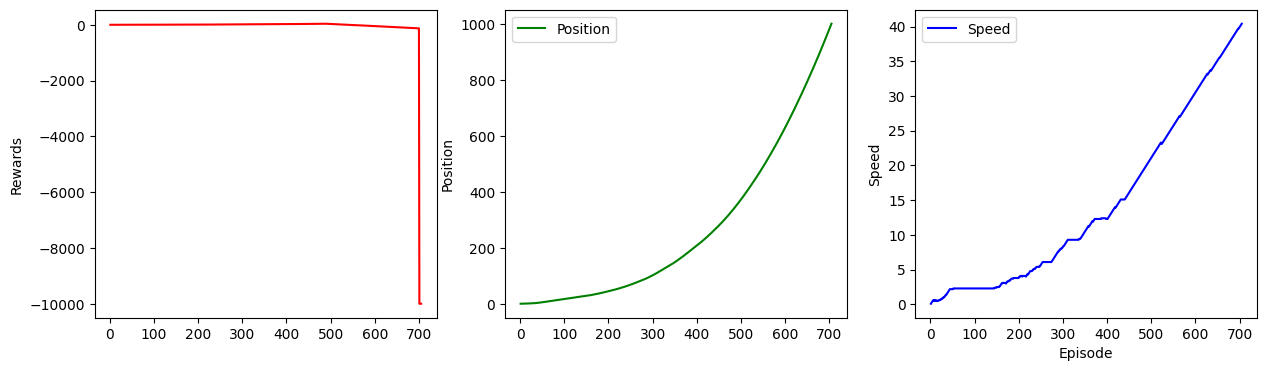

EP: 21	 reward: -1.342e+03	 avg_reward: -1.275e+05	 epsilon: 0.05
EP: 22	 reward: -2.611e+03	 avg_reward: -1.218e+05	 epsilon: 0.05
EP: 23	 reward: 8.262e+03	 avg_reward: -1.162e+05	 epsilon: 0.05
EP: 24	 reward: 7.827e+03	 avg_reward: -1.11e+05	 epsilon: 0.05
EP: 25	 reward: 8.047e+03	 avg_reward: -1.063e+05	 epsilon: 0.05
EP: 26	 reward: 1.296e+04	 avg_reward: -1.017e+05	 epsilon: 0.05
EP: 27	 reward: 8.861e+03	 avg_reward: -9.758e+04	 epsilon: 0.05
EP: 28	 reward: 9.45e+03	 avg_reward: -9.376e+04	 epsilon: 0.05
EP: 29	 reward: 7.553e+03	 avg_reward: -9.026e+04	 epsilon: 0.05
EP: 30	 reward: 9.718e+03	 avg_reward: -8.693e+04	 epsilon: 0.05
EP: 31	 reward: 1.194e+04	 avg_reward: -8.374e+04	 epsilon: 0.05
EP: 32	 reward: 1.291e+04	 avg_reward: -8.072e+04	 epsilon: 0.05
EP: 33	 reward: 1.004e+04	 avg_reward: -7.797e+04	 epsilon: 0.05
EP: 34	 reward: 5.876e+03	 avg_reward: -7.55e+04	 epsilon: 0.05
EP: 35	 reward: 1.217e+04	 avg_reward: -7.3e+04	 epsilon: 0.05
EP: 36	 reward: 1.235e+04	 a

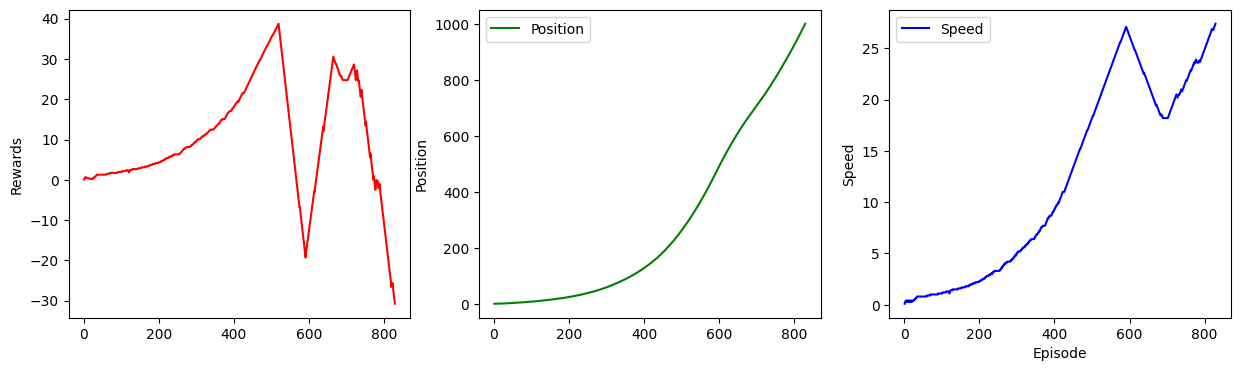

EP: 41	 reward: 1.125e+04	 avg_reward: -6.057e+04	 epsilon: 0.05
EP: 42	 reward: 1.064e+04	 avg_reward: -5.887e+04	 epsilon: 0.05
EP: 43	 reward: 1.064e+04	 avg_reward: -5.726e+04	 epsilon: 0.05
EP: 44	 reward: 6.51e+03	 avg_reward: -5.581e+04	 epsilon: 0.05
EP: 45	 reward: 1.253e+04	 avg_reward: -5.429e+04	 epsilon: 0.05
EP: 46	 reward: 1.443e+04	 avg_reward: -5.28e+04	 epsilon: 0.05
EP: 47	 reward: 1.326e+04	 avg_reward: -5.139e+04	 epsilon: 0.05
EP: 48	 reward: 1.393e+04	 avg_reward: -5.003e+04	 epsilon: 0.05
EP: 49	 reward: 1.186e+04	 avg_reward: -4.877e+04	 epsilon: 0.05
EP: 50	 reward: 9.611e+03	 avg_reward: -4.76e+04	 epsilon: 0.05
EP: 51	 reward: 1.296e+04	 avg_reward: -4.641e+04	 epsilon: 0.05
EP: 52	 reward: 1.336e+04	 avg_reward: -4.526e+04	 epsilon: 0.05
EP: 53	 reward: 1.224e+04	 avg_reward: -4.418e+04	 epsilon: 0.05
EP: 54	 reward: 7.168e+03	 avg_reward: -4.323e+04	 epsilon: 0.05
EP: 55	 reward: 1.324e+04	 avg_reward: -4.22e+04	 epsilon: 0.05
EP: 56	 reward: 1.215e+04	 av

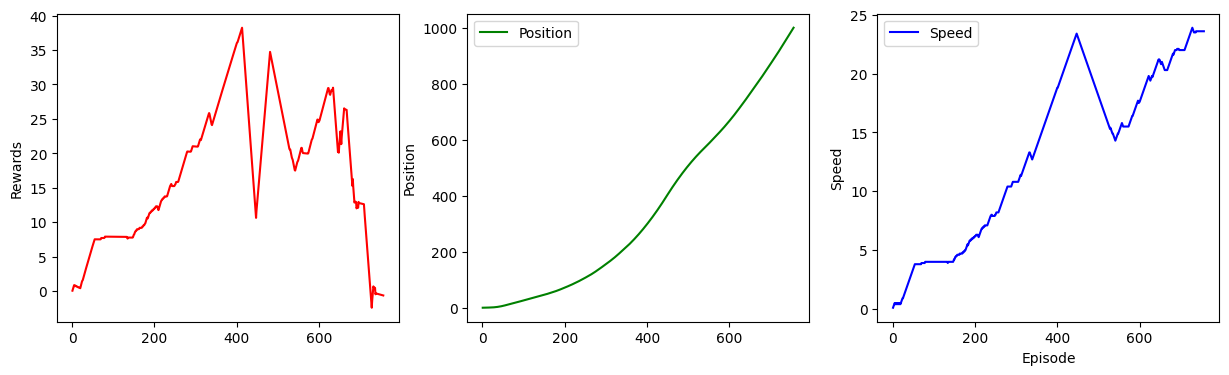

EP: 61	 reward: 1.314e+04	 avg_reward: -3.689e+04	 epsilon: 0.05
EP: 62	 reward: 1.26e+04	 avg_reward: -3.609e+04	 epsilon: 0.05
EP: 63	 reward: 1.337e+04	 avg_reward: -3.53e+04	 epsilon: 0.05
EP: 64	 reward: 1.137e+04	 avg_reward: -3.457e+04	 epsilon: 0.05
EP: 65	 reward: 9.535e+03	 avg_reward: -3.39e+04	 epsilon: 0.05
EP: 66	 reward: 1.603e+04	 avg_reward: -3.314e+04	 epsilon: 0.05
EP: 67	 reward: 1.446e+04	 avg_reward: -3.243e+04	 epsilon: 0.05
EP: 68	 reward: 1.445e+04	 avg_reward: -3.174e+04	 epsilon: 0.05
EP: 69	 reward: 1.451e+04	 avg_reward: -3.107e+04	 epsilon: 0.05
EP: 70	 reward: 1.259e+04	 avg_reward: -3.044e+04	 epsilon: 0.05
EP: 71	 reward: 1.301e+04	 avg_reward: -2.983e+04	 epsilon: 0.05
EP: 72	 reward: 1.264e+04	 avg_reward: -2.924e+04	 epsilon: 0.05
EP: 73	 reward: 1.524e+04	 avg_reward: -2.863e+04	 epsilon: 0.05
EP: 74	 reward: 1.555e+04	 avg_reward: -2.804e+04	 epsilon: 0.05
EP: 75	 reward: 1.456e+04	 avg_reward: -2.747e+04	 epsilon: 0.05
EP: 76	 reward: 1.559e+04	 a

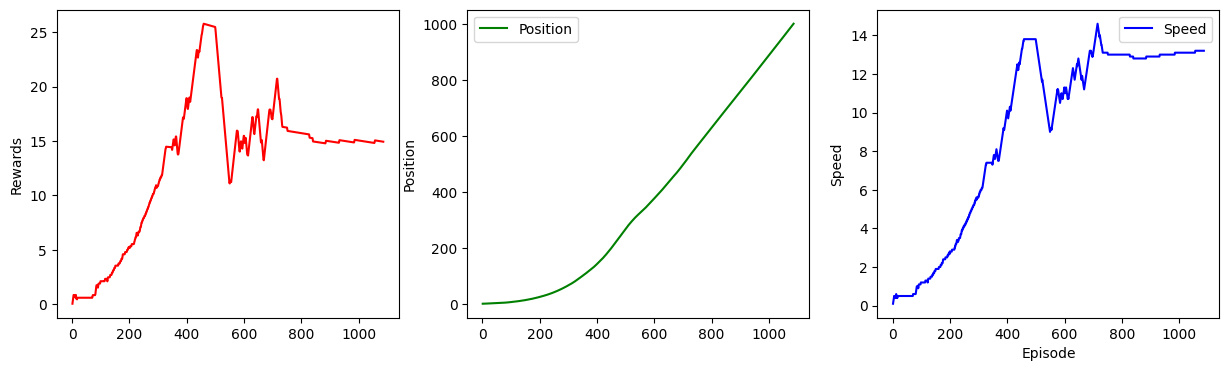

EP: 81	 reward: 1.308e+04	 avg_reward: -2.445e+04	 epsilon: 0.05
EP: 82	 reward: 1.229e+04	 avg_reward: -2.4e+04	 epsilon: 0.05
EP: 83	 reward: 1.286e+04	 avg_reward: -2.356e+04	 epsilon: 0.05
EP: 84	 reward: 1.187e+04	 avg_reward: -2.313e+04	 epsilon: 0.05
EP: 85	 reward: 1.515e+04	 avg_reward: -2.268e+04	 epsilon: 0.05
EP: 86	 reward: 1.403e+04	 avg_reward: -2.226e+04	 epsilon: 0.05
EP: 87	 reward: 1.333e+04	 avg_reward: -2.185e+04	 epsilon: 0.05
EP: 88	 reward: 1.134e+04	 avg_reward: -2.147e+04	 epsilon: 0.05
EP: 89	 reward: 1.46e+04	 avg_reward: -2.106e+04	 epsilon: 0.05
EP: 90	 reward: 1.574e+04	 avg_reward: -2.066e+04	 epsilon: 0.05
EP: 91	 reward: 1.393e+04	 avg_reward: -2.028e+04	 epsilon: 0.05
EP: 92	 reward: 1.559e+04	 avg_reward: -1.989e+04	 epsilon: 0.05
EP: 93	 reward: 1.535e+04	 avg_reward: -1.951e+04	 epsilon: 0.05
EP: 94	 reward: 1.345e+04	 avg_reward: -1.916e+04	 epsilon: 0.05
EP: 95	 reward: 1.165e+04	 avg_reward: -1.883e+04	 epsilon: 0.05
EP: 96	 reward: 1.489e+04	 a

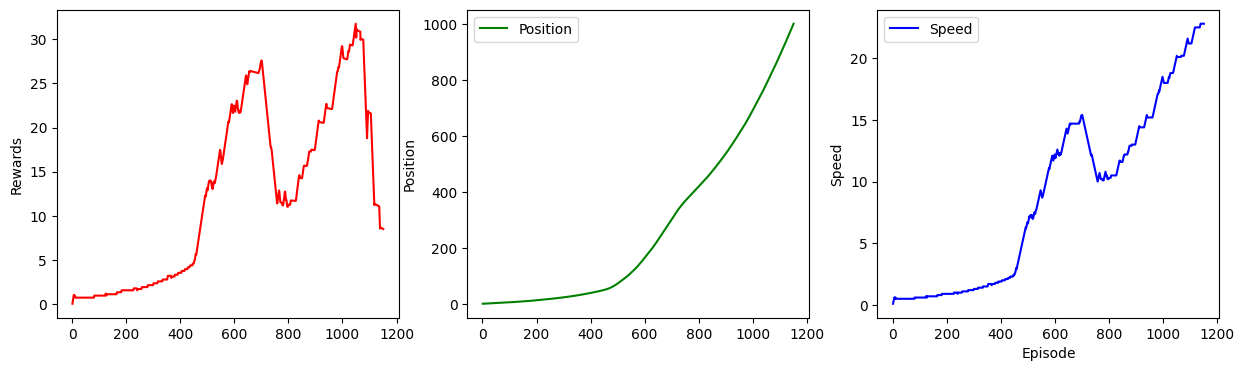

Saving Q_eval network successfully!
Saving Q_target network successfully!
EP: 101	 reward: 1.392e+04	 avg_reward: -1.272e+04	 epsilon: 0.05
EP: 102	 reward: 1.421e+04	 avg_reward: 5.259e+03	 epsilon: 0.05
EP: 103	 reward: 1.538e+04	 avg_reward: 5.243e+03	 epsilon: 0.05
EP: 104	 reward: 1.409e+04	 avg_reward: 5.237e+03	 epsilon: 0.05
EP: 105	 reward: 1.42e+04	 avg_reward: 5.271e+03	 epsilon: 0.05
EP: 106	 reward: 1.358e+04	 avg_reward: 5.328e+03	 epsilon: 0.05
EP: 107	 reward: 5.332e+03	 avg_reward: 5.314e+03	 epsilon: 0.05
EP: 108	 reward: 1.338e+04	 avg_reward: 5.375e+03	 epsilon: 0.05
EP: 109	 reward: 1.396e+04	 avg_reward: 5.441e+03	 epsilon: 0.05
EP: 110	 reward: 1.131e+04	 avg_reward: 5.466e+03	 epsilon: 0.05
EP: 111	 reward: 1.464e+04	 avg_reward: 5.518e+03	 epsilon: 0.05
EP: 112	 reward: 1.191e+04	 avg_reward: 5.715e+03	 epsilon: 0.05
EP: 113	 reward: -6.222e+03	 avg_reward: 8.406e+03	 epsilon: 0.05
EP: 114	 reward: 1.429e+04	 avg_reward: 1.07e+04	 epsilon: 0.05
EP: 115	 reward:

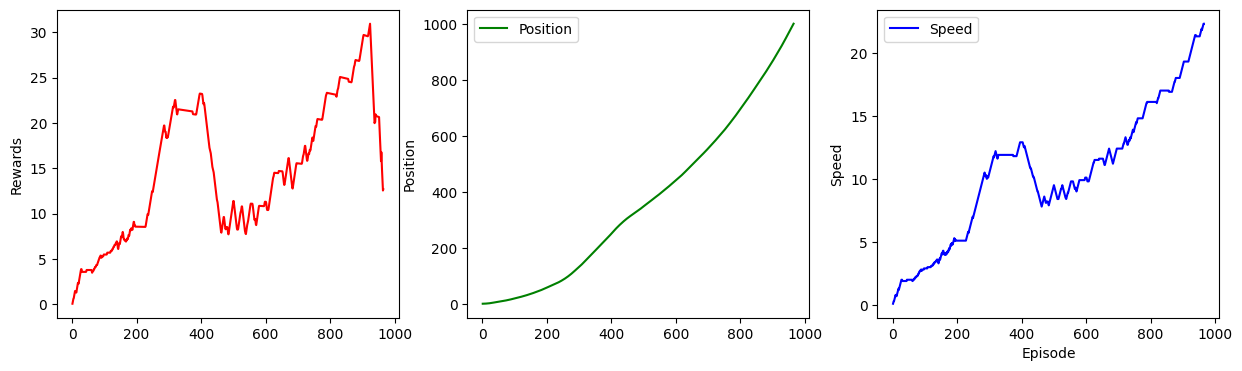

EP: 121	 reward: 1.463e+04	 avg_reward: 1.217e+04	 epsilon: 0.05
EP: 122	 reward: 1.532e+04	 avg_reward: 1.235e+04	 epsilon: 0.05
EP: 123	 reward: 1.208e+04	 avg_reward: 1.239e+04	 epsilon: 0.05
EP: 124	 reward: 8.911e+03	 avg_reward: 1.24e+04	 epsilon: 0.05
EP: 125	 reward: 1.417e+04	 avg_reward: 1.246e+04	 epsilon: 0.05
EP: 126	 reward: 9.695e+03	 avg_reward: 1.243e+04	 epsilon: 0.05
EP: 127	 reward: 1.449e+04	 avg_reward: 1.248e+04	 epsilon: 0.05
EP: 128	 reward: 1.522e+04	 avg_reward: 1.254e+04	 epsilon: 0.05
EP: 129	 reward: 1.487e+04	 avg_reward: 1.261e+04	 epsilon: 0.05
EP: 130	 reward: 1.468e+04	 avg_reward: 1.266e+04	 epsilon: 0.05
EP: 131	 reward: 1.464e+04	 avg_reward: 1.269e+04	 epsilon: 0.05
EP: 132	 reward: 1.65e+04	 avg_reward: 1.273e+04	 epsilon: 0.05
EP: 133	 reward: 1.569e+04	 avg_reward: 1.278e+04	 epsilon: 0.05
EP: 134	 reward: 1.567e+04	 avg_reward: 1.288e+04	 epsilon: 0.05
EP: 135	 reward: 1.392e+04	 avg_reward: 1.29e+04	 epsilon: 0.05
EP: 136	 reward: 1.408e+04	 

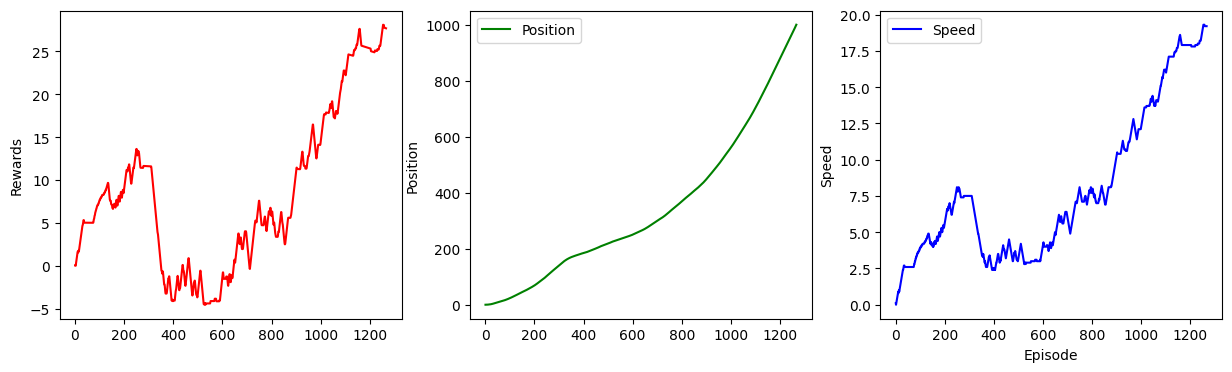

EP: 141	 reward: 8.122e+03	 avg_reward: 1.29e+04	 epsilon: 0.05
EP: 142	 reward: 1.382e+04	 avg_reward: 1.294e+04	 epsilon: 0.05
EP: 143	 reward: 1.537e+04	 avg_reward: 1.298e+04	 epsilon: 0.05
EP: 144	 reward: 1.577e+04	 avg_reward: 1.308e+04	 epsilon: 0.05
EP: 145	 reward: 9.773e+03	 avg_reward: 1.305e+04	 epsilon: 0.05
EP: 146	 reward: 1.338e+04	 avg_reward: 1.304e+04	 epsilon: 0.05
EP: 147	 reward: 1.474e+04	 avg_reward: 1.305e+04	 epsilon: 0.05
EP: 148	 reward: 9.028e+03	 avg_reward: 1.3e+04	 epsilon: 0.05
EP: 149	 reward: 1.47e+04	 avg_reward: 1.303e+04	 epsilon: 0.05
EP: 150	 reward: 1.526e+04	 avg_reward: 1.309e+04	 epsilon: 0.05
EP: 151	 reward: 1.114e+04	 avg_reward: 1.307e+04	 epsilon: 0.05
EP: 152	 reward: 1.491e+04	 avg_reward: 1.309e+04	 epsilon: 0.05
EP: 153	 reward: 1.461e+04	 avg_reward: 1.311e+04	 epsilon: 0.05
EP: 154	 reward: 4.351e+03	 avg_reward: 1.308e+04	 epsilon: 0.05
EP: 155	 reward: 5.559e+03	 avg_reward: 1.3e+04	 epsilon: 0.05
EP: 156	 reward: 4.558e+03	 avg

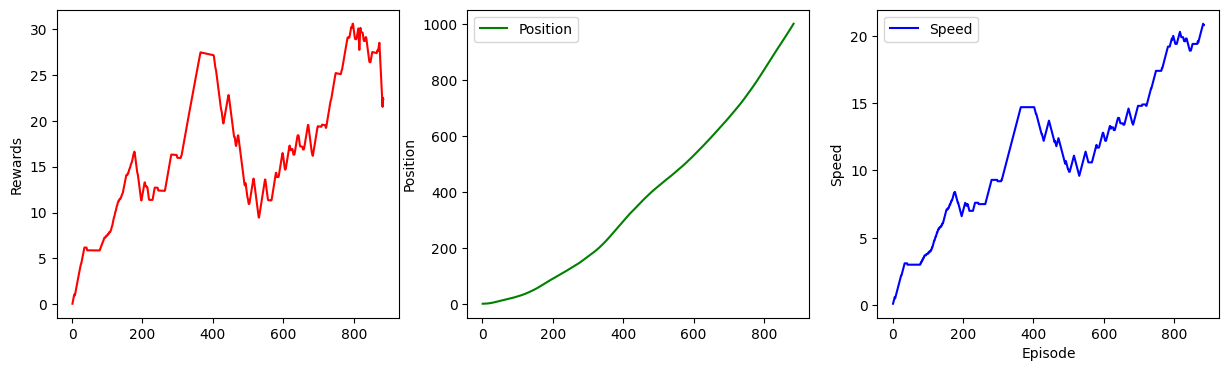

EP: 161	 reward: 1.512e+04	 avg_reward: 1.286e+04	 epsilon: 0.05
EP: 162	 reward: 1.402e+04	 avg_reward: 1.288e+04	 epsilon: 0.05
EP: 163	 reward: 1.009e+04	 avg_reward: 1.284e+04	 epsilon: 0.05
EP: 164	 reward: 1.338e+04	 avg_reward: 1.286e+04	 epsilon: 0.05
EP: 165	 reward: 7.744e+03	 avg_reward: 1.285e+04	 epsilon: 0.05
EP: 166	 reward: 1.361e+04	 avg_reward: 1.282e+04	 epsilon: 0.05
EP: 167	 reward: 1.511e+04	 avg_reward: 1.283e+04	 epsilon: 0.05
EP: 168	 reward: 1.385e+04	 avg_reward: 1.282e+04	 epsilon: 0.05
EP: 169	 reward: 1.421e+04	 avg_reward: 1.282e+04	 epsilon: 0.05
EP: 170	 reward: 3.296e+03	 avg_reward: 1.273e+04	 epsilon: 0.05
EP: 171	 reward: 5.966e+03	 avg_reward: 1.266e+04	 epsilon: 0.05
EP: 172	 reward: 1.263e+04	 avg_reward: 1.266e+04	 epsilon: 0.05
EP: 173	 reward: 1.557e+04	 avg_reward: 1.266e+04	 epsilon: 0.05
EP: 174	 reward: 1.355e+04	 avg_reward: 1.264e+04	 epsilon: 0.05
EP: 175	 reward: 9.819e+03	 avg_reward: 1.259e+04	 epsilon: 0.05
EP: 176	 reward: 9.28e+03

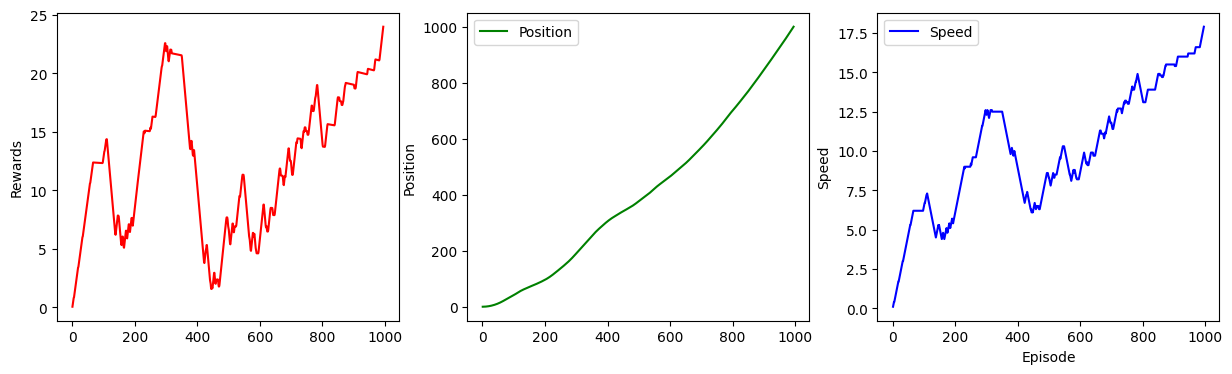

EP: 181	 reward: 1.091e+04	 avg_reward: 1.247e+04	 epsilon: 0.05
EP: 182	 reward: 274.4	 avg_reward: 1.235e+04	 epsilon: 0.05
EP: 183	 reward: -2.431e+03	 avg_reward: 1.219e+04	 epsilon: 0.05
EP: 184	 reward: 2.273e+03	 avg_reward: 1.21e+04	 epsilon: 0.05
EP: 185	 reward: 1.314e+04	 avg_reward: 1.208e+04	 epsilon: 0.05
EP: 186	 reward: 1.405e+04	 avg_reward: 1.208e+04	 epsilon: 0.05
EP: 187	 reward: 1.376e+04	 avg_reward: 1.208e+04	 epsilon: 0.05
EP: 188	 reward: -655.2	 avg_reward: 1.196e+04	 epsilon: 0.05
EP: 189	 reward: 1.446e+04	 avg_reward: 1.196e+04	 epsilon: 0.05
EP: 190	 reward: 1.621e+04	 avg_reward: 1.196e+04	 epsilon: 0.05
EP: 191	 reward: -2.413e+04	 avg_reward: 1.158e+04	 epsilon: 0.05
EP: 192	 reward: 1.285e+04	 avg_reward: 1.156e+04	 epsilon: 0.05
EP: 193	 reward: 1.382e+04	 avg_reward: 1.154e+04	 epsilon: 0.05
EP: 194	 reward: 1.452e+04	 avg_reward: 1.155e+04	 epsilon: 0.05
EP: 195	 reward: 1.506e+04	 avg_reward: 1.159e+04	 epsilon: 0.05
EP: 196	 reward: 9.289e+03	 avg

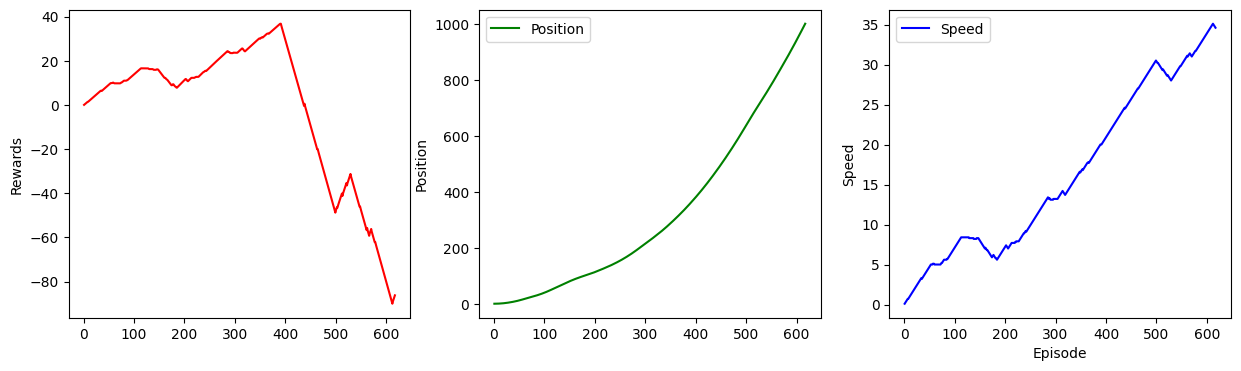

Saving Q_eval network successfully!
Saving Q_target network successfully!
EP: 201	 reward: 1.195e+04	 avg_reward: 1.109e+04	 epsilon: 0.05
EP: 202	 reward: 1.48e+04	 avg_reward: 1.11e+04	 epsilon: 0.05
EP: 203	 reward: 1.361e+03	 avg_reward: 1.096e+04	 epsilon: 0.05
EP: 204	 reward: 1.616e+04	 avg_reward: 1.098e+04	 epsilon: 0.05
EP: 205	 reward: 1.265e+04	 avg_reward: 1.096e+04	 epsilon: 0.05
EP: 206	 reward: 1.479e+04	 avg_reward: 1.097e+04	 epsilon: 0.05
EP: 207	 reward: 1.522e+04	 avg_reward: 1.107e+04	 epsilon: 0.05
EP: 208	 reward: 1.449e+04	 avg_reward: 1.108e+04	 epsilon: 0.05
EP: 209	 reward: 1.352e+04	 avg_reward: 1.108e+04	 epsilon: 0.05
EP: 210	 reward: 1.39e+04	 avg_reward: 1.11e+04	 epsilon: 0.05
EP: 211	 reward: 1.592e+04	 avg_reward: 1.112e+04	 epsilon: 0.05
EP: 212	 reward: 1.428e+04	 avg_reward: 1.114e+04	 epsilon: 0.05
EP: 213	 reward: 8.686e+03	 avg_reward: 1.129e+04	 epsilon: 0.05
EP: 214	 reward: -3.246e+04	 avg_reward: 1.082e+04	 epsilon: 0.05
EP: 215	 reward: 8.

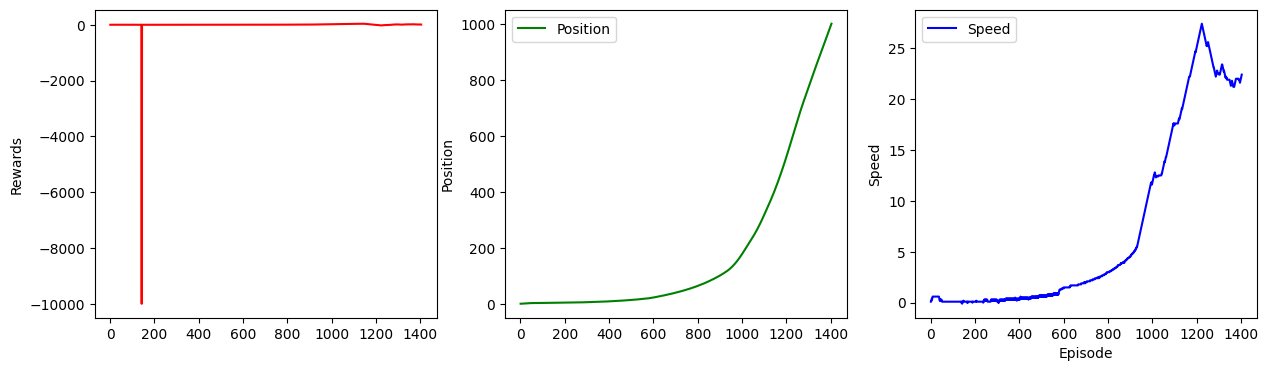

EP: 221	 reward: 1.139e+04	 avg_reward: 1.024e+04	 epsilon: 0.05
EP: 222	 reward: 9.004e+03	 avg_reward: 1.017e+04	 epsilon: 0.05
EP: 223	 reward: 8.806e+03	 avg_reward: 1.014e+04	 epsilon: 0.05
EP: 224	 reward: 5.846e+03	 avg_reward: 1.011e+04	 epsilon: 0.05
EP: 225	 reward: 1.242e+04	 avg_reward: 1.009e+04	 epsilon: 0.05
EP: 226	 reward: 9.46e+03	 avg_reward: 1.009e+04	 epsilon: 0.05
EP: 227	 reward: 8.702e+03	 avg_reward: 1.003e+04	 epsilon: 0.05
EP: 228	 reward: 1.092e+04	 avg_reward: 9.99e+03	 epsilon: 0.05
EP: 229	 reward: 9.192e+03	 avg_reward: 9.933e+03	 epsilon: 0.05
EP: 230	 reward: 7.553e+03	 avg_reward: 9.862e+03	 epsilon: 0.05
EP: 231	 reward: 1.31e+04	 avg_reward: 9.846e+03	 epsilon: 0.05
EP: 232	 reward: 8.394e+03	 avg_reward: 9.765e+03	 epsilon: 0.05
EP: 233	 reward: 9.267e+03	 avg_reward: 9.701e+03	 epsilon: 0.05
EP: 234	 reward: 9.566e+03	 avg_reward: 9.64e+03	 epsilon: 0.05
EP: 235	 reward: 9.304e+03	 avg_reward: 9.594e+03	 epsilon: 0.05
EP: 236	 reward: 4.444e+03	 a

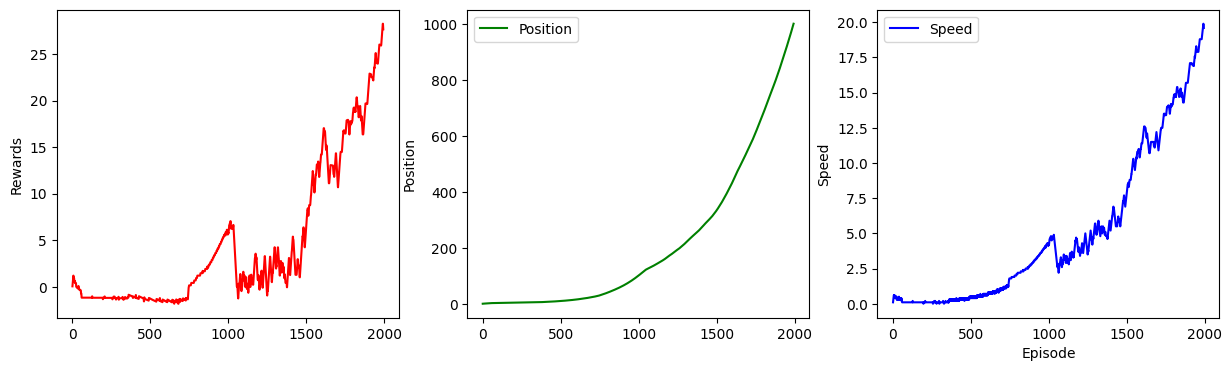

EP: 241	 reward: 9.177e+03	 avg_reward: 9.23e+03	 epsilon: 0.05
EP: 242	 reward: 130.6	 avg_reward: 9.093e+03	 epsilon: 0.05
EP: 243	 reward: -1.376e+03	 avg_reward: 8.925e+03	 epsilon: 0.05
EP: 244	 reward: 1.226e+04	 avg_reward: 8.89e+03	 epsilon: 0.05
EP: 245	 reward: 1.317e+04	 avg_reward: 8.924e+03	 epsilon: 0.05
EP: 246	 reward: 1.277e+04	 avg_reward: 8.918e+03	 epsilon: 0.05
EP: 247	 reward: 1.218e+04	 avg_reward: 8.893e+03	 epsilon: 0.05
EP: 248	 reward: 1.071e+04	 avg_reward: 8.909e+03	 epsilon: 0.05
EP: 249	 reward: 1.668e+03	 avg_reward: 8.779e+03	 epsilon: 0.05
EP: 250	 reward: 1.137e+04	 avg_reward: 8.74e+03	 epsilon: 0.05
EP: 251	 reward: 1.011e+04	 avg_reward: 8.73e+03	 epsilon: 0.05
EP: 252	 reward: 9.976e+03	 avg_reward: 8.68e+03	 epsilon: 0.05
EP: 253	 reward: -1.305e+04	 avg_reward: 8.404e+03	 epsilon: 0.05
EP: 254	 reward: 1.398e+04	 avg_reward: 8.5e+03	 epsilon: 0.05
EP: 255	 reward: 1.056e+04	 avg_reward: 8.55e+03	 epsilon: 0.05
EP: 256	 reward: 1.424e+04	 avg_rew

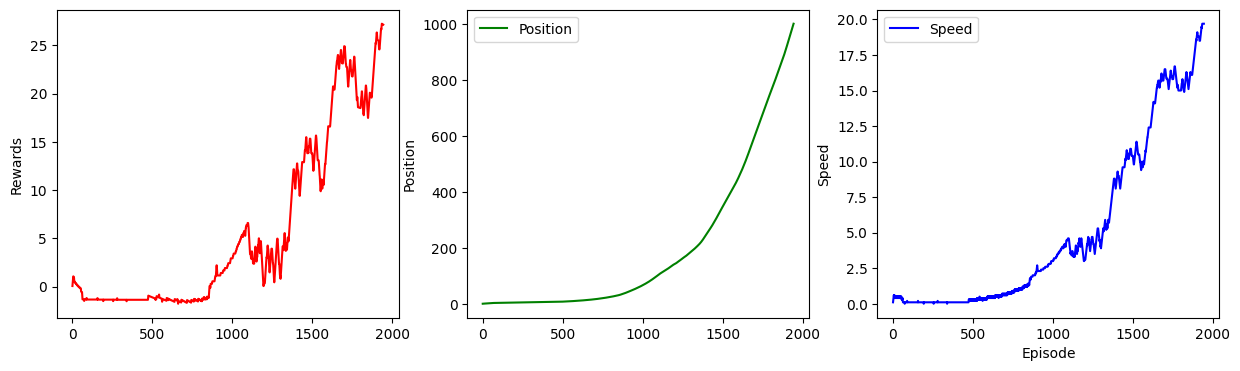

EP: 261	 reward: 1.291e+04	 avg_reward: 8.588e+03	 epsilon: 0.05
EP: 262	 reward: -2.084e+03	 avg_reward: 8.427e+03	 epsilon: 0.05
EP: 263	 reward: 1.406e+04	 avg_reward: 8.466e+03	 epsilon: 0.05
EP: 264	 reward: 1.084e+03	 avg_reward: 8.343e+03	 epsilon: 0.05
EP: 265	 reward: -1.509e+04	 avg_reward: 8.115e+03	 epsilon: 0.05
EP: 266	 reward: 1.172e+04	 avg_reward: 8.096e+03	 epsilon: 0.05
EP: 267	 reward: 680.3	 avg_reward: 7.952e+03	 epsilon: 0.05
EP: 268	 reward: 1.395e+04	 avg_reward: 7.953e+03	 epsilon: 0.05
EP: 269	 reward: 1.201e+04	 avg_reward: 7.931e+03	 epsilon: 0.05
EP: 270	 reward: 1.344e+04	 avg_reward: 8.032e+03	 epsilon: 0.05
EP: 271	 reward: 1.047e+04	 avg_reward: 8.077e+03	 epsilon: 0.05
EP: 272	 reward: 1.012e+04	 avg_reward: 8.052e+03	 epsilon: 0.05
EP: 273	 reward: 8.645e+03	 avg_reward: 7.983e+03	 epsilon: 0.05
EP: 274	 reward: 1.223e+04	 avg_reward: 7.97e+03	 epsilon: 0.05
EP: 275	 reward: 5.793e+03	 avg_reward: 7.929e+03	 epsilon: 0.05
EP: 276	 reward: 1.235e+04	 

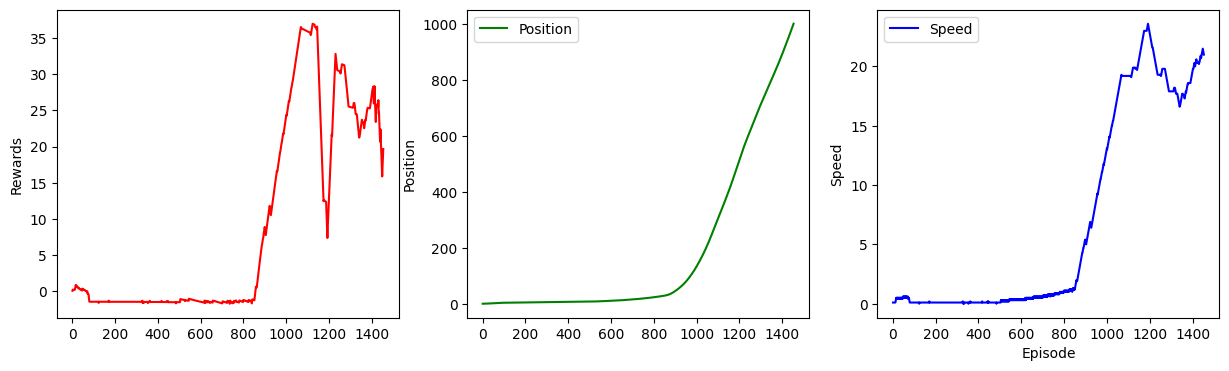

EP: 281	 reward: 1.527e+04	 avg_reward: 7.868e+03	 epsilon: 0.05
EP: 282	 reward: 1.393e+04	 avg_reward: 8.005e+03	 epsilon: 0.05
EP: 283	 reward: 6.814e+03	 avg_reward: 8.097e+03	 epsilon: 0.05
EP: 284	 reward: 9.861e+03	 avg_reward: 8.173e+03	 epsilon: 0.05
EP: 285	 reward: -1.37e+04	 avg_reward: 7.905e+03	 epsilon: 0.05
EP: 286	 reward: 1.34e+03	 avg_reward: 7.778e+03	 epsilon: 0.05
EP: 287	 reward: -874.6	 avg_reward: 7.631e+03	 epsilon: 0.05
EP: 288	 reward: 5.579e+03	 avg_reward: 7.694e+03	 epsilon: 0.05
EP: 289	 reward: 1.437e+04	 avg_reward: 7.693e+03	 epsilon: 0.05
EP: 290	 reward: -1.393e+04	 avg_reward: 7.391e+03	 epsilon: 0.05
EP: 291	 reward: -7.11e+03	 avg_reward: 7.561e+03	 epsilon: 0.05
EP: 292	 reward: 1.431e+03	 avg_reward: 7.447e+03	 epsilon: 0.05
EP: 293	 reward: 1.146e+04	 avg_reward: 7.424e+03	 epsilon: 0.05
EP: 294	 reward: 1.063e+03	 avg_reward: 7.289e+03	 epsilon: 0.05
EP: 295	 reward: 1.02e+04	 avg_reward: 7.24e+03	 epsilon: 0.05
EP: 296	 reward: 1.353e+04	 av

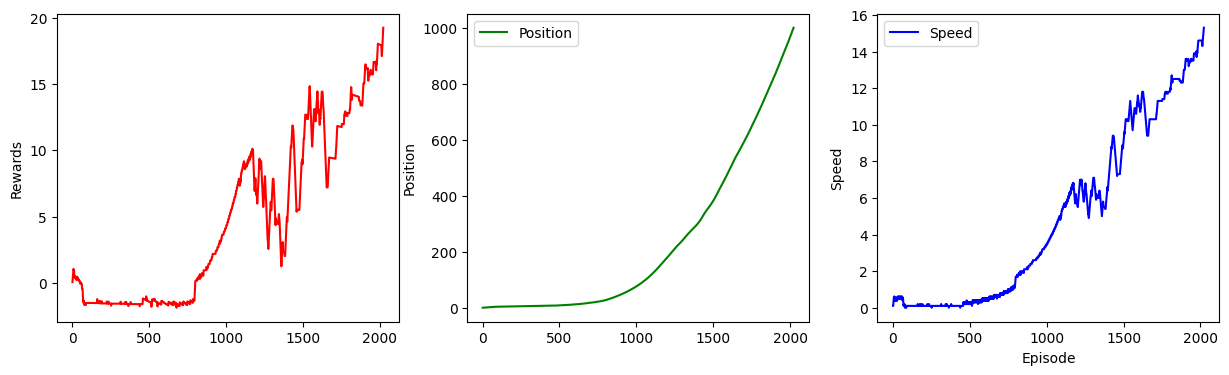

Saving Q_eval network successfully!
Saving Q_target network successfully!
EP: 301	 reward: -1.105e+04	 avg_reward: 7.37e+03	 epsilon: 0.05
EP: 302	 reward: -5.825e+03	 avg_reward: 7.164e+03	 epsilon: 0.05
EP: 303	 reward: 1.308e+04	 avg_reward: 7.281e+03	 epsilon: 0.05
EP: 304	 reward: -1.69e+04	 avg_reward: 6.951e+03	 epsilon: 0.05
EP: 305	 reward: -6.757e+03	 avg_reward: 6.757e+03	 epsilon: 0.05
EP: 306	 reward: 242.0	 avg_reward: 6.611e+03	 epsilon: 0.05
EP: 307	 reward: 1.191e+04	 avg_reward: 6.578e+03	 epsilon: 0.05
EP: 308	 reward: 1.277e+04	 avg_reward: 6.561e+03	 epsilon: 0.05
EP: 309	 reward: 9.795e+03	 avg_reward: 6.524e+03	 epsilon: 0.05
EP: 310	 reward: 1.355e+04	 avg_reward: 6.52e+03	 epsilon: 0.05
EP: 311	 reward: 1.435e+04	 avg_reward: 6.505e+03	 epsilon: 0.05
EP: 312	 reward: 1.297e+04	 avg_reward: 6.491e+03	 epsilon: 0.05
EP: 313	 reward: 1.028e+04	 avg_reward: 6.507e+03	 epsilon: 0.05
EP: 314	 reward: -6.619e+03	 avg_reward: 6.766e+03	 epsilon: 0.05
EP: 315	 reward: 1

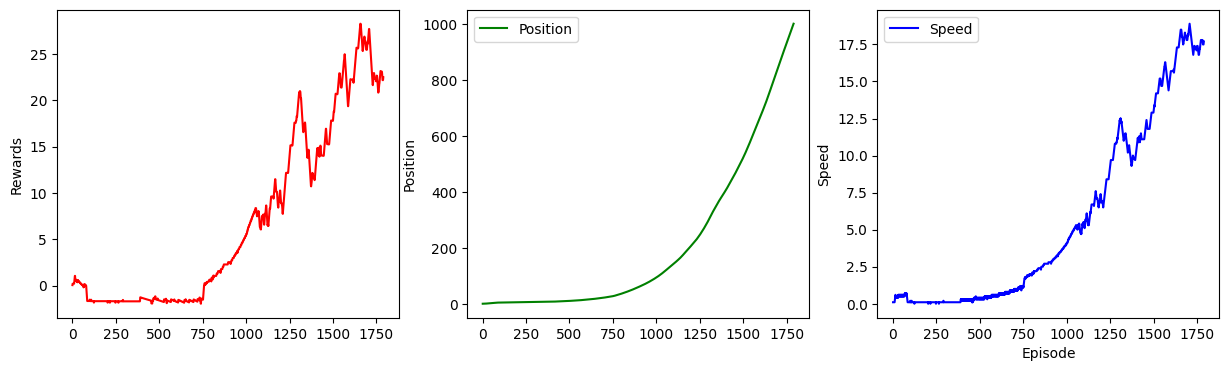

EP: 321	 reward: 1.03e+04	 avg_reward: 7.196e+03	 epsilon: 0.05
EP: 322	 reward: -1.743e+04	 avg_reward: 6.932e+03	 epsilon: 0.05


In [ ]:
import argparse
# from DQN import DQN
# from utils import plot_learning_curve, create_directory

parser = argparse.ArgumentParser()
parser.add_argument('--max_episodes', type=int, default=500)
parser.add_argument('--ckpt_dir', type=str, default='./checkpoints/DQN/')
parser.add_argument('--reward_path', type=str, default='./output_images/avg_reward.png')
parser.add_argument('--epsilon_path', type=str, default='./output_images/epsilon.png')

args, unknown = parser.parse_known_args()


def main():
    env = EcoDrivingEnv()

    agent = DQN(alpha=0.0003, state_dim=env.observation_space.shape[0], action_dim=env.action_space.n,
                fc1_dim=128, fc2_dim=128, ckpt_dir=args.ckpt_dir, gamma=0.90, tau=0.005, epsilon=1.0,
                eps_end=0.05, eps_dec=5e-4, max_size=1000000, batch_size=256)
    
    create_directory(args.ckpt_dir, sub_dirs=['Q_eval', 'Q_target'])
    total_rewards, avg_rewards, eps_history = [], [], []

    for episode in range(args.max_episodes):
        total_reward = 0
        done = False
        observation = env.reset()

        # Record
        states = []
        rewards = []

        while not done:
            action = agent.choose_action(observation, isTrain=True)
            observation_, reward, done, info = env.step(action)
            agent.remember(observation, action, reward, observation_, done)
            agent.learn()
            total_reward += reward
            observation = observation_

            states.append(observation)
            rewards.append(reward)
            # print(info)
            

        total_rewards.append(total_reward)
        avg_reward = np.mean(total_rewards[-100:])
        avg_rewards.append(avg_reward)
        eps_history.append(agent.epsilon)
        
        print('EP: {}\t reward: {:.4}\t avg_reward: {:.4}\t epsilon: {:.4}'.
              format(episode + 1, total_reward, avg_reward, agent.epsilon))
        
        states = np.array(states)

        # Visualize every 20 episodes
        if (episode + 1) % 20 == 0:
          visualize_profile(rewards, states)

        # Save model every 100 episodes
        if (episode + 1) % 100 == 0:
            agent.save_models(episode + 1)

    episodes = [i for i in range(args.max_episodes)]
    plot_learning_curve(episodes, avg_rewards, 'Reward', 'reward', args.reward_path)
    plot_learning_curve(episodes, eps_history, 'Epsilon', 'epsilon', args.epsilon_path)


if __name__ == '__main__':
    main()